In [1]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import re
from nltk import tokenize
import numpy as np

stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Trista\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Convert Words to Vectors

Load text, remove special characters and stopwords if applicable

In [2]:
def preprocess_text(stopwords='no'):
    file_contents = []
    with open('word2vec.txt') as f:
        file_contents = f.read()

    sentences = tokenize.sent_tokenize(file_contents)
    text = []

    for s in sentences:
        s = re.sub(r"[^a-zA-Z0-9]+", ' ', s)
        s = s.lower()

        if stopwords == 'yes' and len(s) > 1: 
            sentence = remove_stopwords(s)
        
        text.append(sentence)
        
    return text

def remove_stopwords(text):
    words = text.split(' ')
    sentence = ''

    for word in words:
        if word not in stop_words:
            sentence += word + ' '
    
    return sentence

In [3]:
text = preprocess_text(stopwords='yes')

Build dictionaries to store word indexes (word to index & index to word)

In [4]:
def build_dict(text):
    word_to_index = {}
    index_to_word = {}
    corpus = []
    index = 0

    for s in text:
        for word in s.split(' '):
            word = word.lower()

            if len(word) > 0:
                corpus.append(word)
                if word_to_index.get(word) == None:
                    word_to_index.update({word: index})
                    index_to_word.update({index: word})
                    index += 1
    
    return word_to_index, index_to_word, corpus

Generate one-hot-vector to each unique word

In [5]:
def one_hot_vec(target_word, context_words, corpus, word_to_index, index_to_word):
    size_vocab = len(word_to_index)
    target_word_vec = np.zeros(size_vocab)
    context_words_vec = np.zeros(size_vocab)  # set the context words into one vector to save space

    target_index = word_to_index.get(target_word)
    target_word_vec[target_index] = 1

    for word in context_words:
        context_index = word_to_index.get(word)
        context_words_vec[context_index] = 1
        
    return target_word_vec, context_words_vec

Prepare the training dataset

In [12]:
def generate_training_data(window_size, corpus, word_to_index, index_to_word):
    training_data = []

    for i, word in enumerate(corpus):
        context_word = []
        if i == 0:
            context_word = corpus[(i + 1): (i + 1 + window_size)]      
        elif i == len(corpus) - 1:
            context_word = corpus[(i - window_size): i]
        else:
            if i - window_size < 0:
                context_word = corpus[0: i] + corpus[(i + 1): (i + 1 + window_size)]
            elif i + window_size > len(corpus):
                context_word = corpus[(i - window_size): i] + corpus[(i + 1): len(corpus)]              
            else:
                context_word = corpus[(i - window_size): i] + corpus[(i + 1): (i + 1 + window_size)]
            
        target_word_vec, context_words_vec = one_hot_vec(word, context_word, corpus, word_to_index, index_to_word)
        training_data.append([target_word_vec, context_words_vec])
    
    return training_data

Test for functions

In [37]:
text = ['natural language processing and machine learning is fun and exciting']

In [13]:
window_size = 2
word_to_index, index_to_word, corpus = build_dict(text)
training_words = generate_training_data(window_size, corpus, word_to_index, index_to_word)

# Model Training - Skip-gram Model

Forward Propogation

In [8]:
def forward_prop(input_weights, hidden_weights, X):
    hidden_layer = np.dot(X, input_weights)
    output_layer = np.dot(hidden_layer, hidden_weights)
    y_hat = softmax(output_layer)
    
    return y_hat, hidden_layer, output_layer

def softmax(Z):
    e_x = np.exp(Z - np.max(Z))
    return e_x / e_x.sum(axis=0)


Cost Function

In [24]:
def error_fun(context_words_vec, y_hat):
    vector_list = []
    length = len(context_words_vec)
    errors = []

    for i in range(length):
        if context_words_vec[i] == 1:
            vec = [0 if k != i else 1 for k in range(length)]
            vector_list.append(vec)

    error = np.zeros(length)
    for vec in vector_list:
        error += np.subtract(y_hat, vec)
    errors.append(error)
    
    errors = np.array(errors)
        
    return errors

Back Propogation

In [26]:
def back_prop(y_hat, input_weights, hidden_weights, 
              error, hidden_layer, learning_rate, target_word_vec):
    delta_input_weights = np.outer(target_word_vec, np.dot(hidden_weights, error.T))
    delta_hidden_weights = np.outer(hidden_layer, error)
    
    # update weights
    input_weights_updated = input_weights - learning_rate * delta_input_weights
    hidded_weights_updated = hidden_weights - learning_rate * delta_hidden_weights
    
    return input_weights_updated, hidded_weights_updated

Calculate loss

In [21]:
def loss_fun(output_layer, context_words_vec): 
    total_loss = 0
    
    sum1 = 0

    for index in np.where(context_words_vec == 1)[0]:
        sum1 += output_layer[index]

    sum1 = -sum1
    sum2 = len(np.where(context_words_vec == 1)[0]) * np.log(np.sum(np.exp(output_layer)))

    loss = sum1 + sum2
    total_loss += loss
    
    return total_loss

Train Model

In [19]:
def train(word_embedding_size, training_words, learning_rate, num_epoch):
    vocab_size = training_target_words.shape[1]

    input_weights = np.random.uniform(-1, 1, (vocab_size, word_embedding_size))
    hidden_weights = np.random.uniform(-1, 1, (word_embedding_size, vocab_size))
    
    epoch_loss = []
    weights_1 = []
    weights_2 = []
    total_loss = 0
    
    for i in range(num_epoch):
        
        for target_word, context_word in training_words:
            y_hat, hidden_layer, output_layer = forward_prop(input_weights, hidden_weights, target_word)
            error = error_fun(context_word, y_hat)
            input_weights, hidden_weights = back_prop(y_hat, input_weights, hidden_weights, 
                          error, hidden_layer, learning_rate, target_word)
            loss = loss_fun(output_layer, context_word)
            total_loss += loss
    
        epoch_loss.append(loss)
        weights_1.append(input_weights)
        weights_2.append(hidden_weights)
        
    
    return epoch_loss, weights_1, weights_2

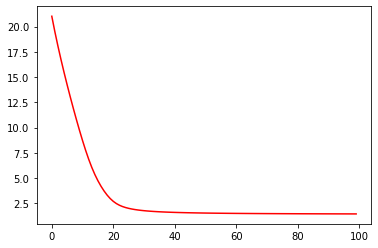

In [30]:
import matplotlib.pyplot as plt

epoch_num = 100
learning_rate = 0.01
word_embedding_size = 100
epoch_loss, weights_1, weights_2 = train(word_embedding_size, training_words, learning_rate, epoch_num)

plt.plot(list(range(epoch_num)), epoch_loss, '-r')